### Combining programs properly

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



import warnings
warnings.filterwarnings("ignore")
from analysis_functions import *


In [2]:
mouse = 56165      ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 1
period = int(10 * sf / re_sf)
period_resting = period *50
N_SHUFFLINGS = 50
colorcodes = ['Greys','PuBu', 'YlOrRd','Reds','Blues','Oranges','Greens']


In [3]:
task,colapse_behaviour,object_fixed,fixed,labels,colornames = mouse_properties(mouse = mouse, session_now = session_now)

In [4]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'

In [ ]:
activity_list,timeline_list,behaviour_list,corners_list,parameters_time,parameters_list,parameters_list2, speed_list = load_data(mouse, session_now,decoding_v, motion_correction_v, alignment_v, equalization_v,source_extraction_v,component_evaluation_v, re_sf,file_directory, timeline_file_dir, behaviour_dir, behaviour_dir_parameters, tracking_dir, objects_dir)

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
(195, 32368)
(448, 30592)
(322, 31977)
(397, 30905)


In [6]:
data_transformation = transform_neural_data(activity_list, behaviour_list,parameters_time,parameters_list,parameters_list2)

In [7]:
create_task_behaviour(behaviour_list,colapse_behaviour,object_fixed)

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [8]:
print('CREATING CORNERS VECTORS VECTORS')
navigation_list, exploration_list = create_corners_occupation(behaviour_list, corners_list, speed_list)


CREATING CORNERS VECTORS VECTORS


In [9]:
print('CREATES LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS')
### ethogram events list
events_etho, events_shuffle_etho,events_counter_etho,events_onset_etho = create_events_list(behaviour_list, N_SHUFFLINGS)
### navigation events list
events_nav, events_shuffle_nav,events_counter_nav,events_onset_nav = create_events_list(navigation_list, N_SHUFFLINGS)
### exploration events list
events_exp, events_shuffle_exp,events_counter_exp,events_onset_exp = create_events_list(exploration_list, N_SHUFFLINGS)


CREATES LIST THAT SAVES ALL THE EVENTS IN A DAY AND CONTAINS ONSET OF VISITS


In [10]:
print('NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT')
## compute events duration for type of event. Here we create lists that we can access to know the duration of each ID event
## we will use this to balance the dataset
# id_for ethogram object exploration
id_target_etho = [3,4]
events_duration_etho, total_duration_etho,number_of_events_etho,events_id_etho = create_id_events(events_etho, events_counter_etho,events_onset_etho,id_target_etho)

# id for corners navigation
id_target_corners = [1,2,3,4]
events_duration_nav, total_duration_nav,number_of_events_nav,events_id_nav = create_id_events(events_nav, events_counter_nav,events_onset_nav,id_target_corners)

# id for corners navigation with objects
id_target_exp = [1,2,3,4]
events_duration_exp, total_duration_exp,number_of_events_exp,events_id_exp = create_id_events(events_exp, events_counter_exp,events_onset_exp,id_target_exp)

NOW WE SEPARATE EVENTS TYPES ACCORDING TO CORNER/OBJECT VISIT


In [11]:
print('BALANCING TO THE LOWER NUMBER OF VISITS: ethogram')
events_number_etho, events_etho_b, events_etho_s_b = balancing_visits(number_of_events_etho,events_duration_etho,events_id_etho)
print('BALANCING TO THE LOWER NUMBER OF VISITS: corners navigation')
events_number_nav, events_nav_b, events_nav_s_b = balancing_visits(number_of_events_nav,events_duration_nav,events_id_nav)
print('BALANCING TO THE LOWER NUMBER OF VISITS: exploration navigation')
events_number_exp, events_exp_b, events_exp_s_b = balancing_visits(number_of_events_exp,events_duration_exp,events_id_exp)

BALANCING TO THE LOWER NUMBER OF VISITS: ethogram
Number of events per day after balancing:  59
Number of events per day after balancing:  97
Number of events per day after balancing:  75
Number of events per day after balancing:  76
BALANCING TO THE LOWER NUMBER OF VISITS: corners navigation
Number of events per day after balancing:  11
Number of events per day after balancing:  34
Number of events per day after balancing:  25
Number of events per day after balancing:  25
BALANCING TO THE LOWER NUMBER OF VISITS: exploration navigation
Number of events per day after balancing:  10
Number of events per day after balancing:  5
Number of events per day after balancing:  9
Number of events per day after balancing:  9


In [12]:
print('CREATE SHUFFLE LABELS THAT PRESERVE BALANCE')
events_etho_shuffle_b = create_shuffling(events_etho,events_shuffle_etho,events_counter_etho,events_onset_etho,number_of_events_etho,events_id_etho,events_etho_b,N_SHUFFLINGS)
events_nav_shuffle_b = create_shuffling(events_nav,events_shuffle_nav,events_counter_nav,events_onset_nav,number_of_events_nav,events_id_nav,events_nav_b,N_SHUFFLINGS)
events_exp_shuffle_b = create_shuffling(events_exp,events_shuffle_exp,events_counter_exp,events_onset_exp,number_of_events_exp,events_id_exp,events_exp_b,N_SHUFFLINGS)

CREATE SHUFFLE LABELS THAT PRESERVE BALANCE


In [13]:
print('TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that')
activity_events_etho = create_events_activity_data_transformation(activity_list,data_transformation,period,events_etho,events_counter_etho,events_onset_etho,events_id_etho,events_etho_b)
activity_events_etho_shuffling = create_events_activity_data_transformation_shuffling(activity_list,data_transformation,period,events_etho_shuffle_b,events_counter_etho,events_onset_etho,events_id_etho,events_etho_s_b, N_SHUFFLINGS)
print('CREATING VISITIS ACTIVITY MATRICES')
trial_activity_etho = create_trial_activity_list(activity_events_etho,events_id_etho)
trial_activity_shuffle_etho = create_trial_activity_list_shuffle(activity_events_etho_shuffling,events_id_etho, N_SHUFFLINGS)
print('CREATING DISTANCE')


TAKING NEURAL OR TRANSFORMED ACTIVITY FOR EACH EVENT ... and create list with that
CREATEING VISITIS ACTIVITY MATRICES


In [14]:
print('CREATING DISTANCE tuple')
distance_etho = compute_distance_list(trial_activity_etho,trial_activity_shuffle_etho, N_SHUFFLINGS)

CREATEING VISITIS ACTIVITY MATRICES


In [15]:

def compute_distance_list(trial_activity, trial_activity_shuffle, N_SHUFFLINGS):

    distance_neural, z_scored_neural = compute_representational_distance(trial_activity.neural,trial_activity_shuffle.neural,trial_activity_etho.neural.shape[1], N_SHUFFLINGS)
    pca_components = np.where(data_transformation.variance_ratio[0]>0.7)[0][0]
    distance_pca, z_scored_pca = compute_representational_distance(trial_activity.pca,trial_activity_shuffle.pca,pca_components, N_SHUFFLINGS)
    distance_cca_time, z_scored_cca_time = compute_representational_distance(trial_activity.cca_time,trial_activity_shuffle.cca_time,trial_activity.cca_time.shape[1], N_SHUFFLINGS)
    distance_cca_allo, z_scored_cca_allo = compute_representational_distance(trial_activity.cca_allo,trial_activity_shuffle.cca_allo,trial_activity.cca_allo.shape[1], N_SHUFFLINGS)
    distance_cca_ego, z_scored_cca_ego = compute_representational_distance(trial_activity.cca_ego,trial_activity_shuffle.cca_ego,trial_activity.cca_ego.shape[1], N_SHUFFLINGS)
    distance_lda, z_scored_cca_lda = compute_representational_distance(trial_activity.lda,trial_activity_shuffle.lda,trial_activity.lda.shape[1], N_SHUFFLINGS)

    distance = namedtuple('distance', ['neural','pca','cca_time','cca_allo','cca_ego','lda'])
    return distance(z_scored_neural, z_scored_pca, z_scored_cca_time, z_scored_cca_allo, z_scored_cca_ego, z_scored_cca_lda)



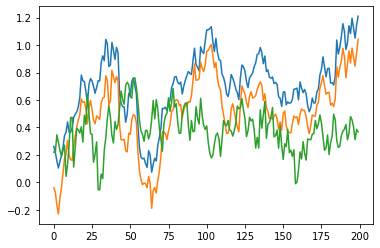

In [19]:
plt.plot(distance_etho.neural)
plt.plot(distance_etho.pca)
plt.plot(distance_etho.cca_time)

##### 

In [20]:
pca_components

20

CREATEING VISITIS ACTIVITY MATRICES SHUFFLINGS


[[1.95939956 1.94699135 1.98911795 ... 1.74201068 1.87321813 1.86176723]
 [2.31295773 2.31173336 2.38813441 ... 2.30902708 2.48124284 2.47540232]
 [1.59436514 1.53040513 1.52196254 ... 1.76378585 1.70466153 1.67105339]
 ...
 [1.97801186 1.85414674 1.82911365 ... 1.95784054 1.98825433 2.00732658]
 [1.98599953 2.11182856 2.21215681 ... 1.70420523 1.72847174 1.67116494]
 [2.34433118 2.38180128 2.49013915 ... 2.16177615 2.1466189  2.14891163]]


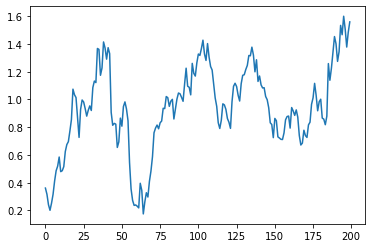